In [1]:
import re
from collections import Counter
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
from itertools import groupby

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_full = pd.read_feather('../data/04_secondary/ads.feather').set_index('Id')

In [3]:
df = df_full.drop_duplicates(['uid'])

In [4]:
WHITESPACE = re.compile('\s+')
def tokenize(s):
    '''Split a string into tokens'''
    return WHITESPACE.split(s)

In [5]:
def num_tokens(s):
    return len(tokenize(s))

In [6]:
def untokenize(s):
    '''Join tokens into a string'''
    return ' '.join(s)

In [7]:
title_words = df.Title.apply(num_tokens)

Cumulative counts: most job ads titles are 2-8 words long.
Maximum is 25.

In [8]:
title_words.value_counts().sort_index().cumsum() / len(df)

1     0.027751
2     0.263872
3     0.508512
4     0.667297
5     0.780141
6     0.861097
7     0.916366
8     0.952158
9     0.974050
10    0.986138
11    0.992728
12    0.996118
13    0.997855
14    0.998744
15    0.999254
16    0.999576
17    0.999741
18    0.999797
19    0.999865
20    0.999910
21    0.999940
22    0.999959
23    0.999985
24    0.999996
25    1.000000
Name: Title, dtype: float64

In [9]:
role_words = [
 'manager',
 'engineer',
 'executive',
 'assistant',
 'accountant',
 'administrator',
 'developer',
 'analyst',
 'controller',
 'teacher',
 'consultant',
 'advisor',
 'cleaner',
 'officer',
 'worker',
 'nurse',
 'operative',
 'surveyor',
 'technician',
 'clerk',
 'chef',
 'director',
 'coordinator',
 'supervisor',
 'partner',
 'labourer',
 'secretary',
 'receptionist',
 'buyer',
 'planner',
 'designer',
 'estimator',
 'senior',
 'leader',
 #'partie', # Part of chef de partie, specific title
 'solicitor',
 'driver',
 'auditor',
 'electrician',
 'negotiator',
 'fitter',
 'operator',
 'turner',
 #'workers', # Plural of worker
 'representative',
 'handler',
 'machinist',
 'miller',
 'welder',
 'inspector',
 'associate',
 #'pa', # Acronym
 'therapist',
 'architect',
 # 'dba', # Acronym
 'bookkeeper',
 'programmer',
 'control', # Is "Quality Control" and "Quality controller" the same thing?
 'telesales', #s', # This is a linguistic exception; telesalesperson?
 'resourcer',
 #'sales', # This is often a role, but is problematic
 'merchandiser',
 #'rgn', # Acronym
 'bricklayer',
 'toolmaker',
 'groundworker',
 # 'finance', # This needs to be part of a role, doesn't make sense by itself
 'cook',
 'optometrist',
 'cashier',
 'paraplanner',
 'author',
 'agent',
 # 'marketing',
 'paralegal',
 'trainer',
 'fellow',
 #'service', # customer service
 'fundraiser',
 'technologist',
 'carpenter',
 'joiner',
 'plumber',
 'caretaker',
 'housekeeper',
 'telemarketer',
 'ledger',
 'studentship',
 # 'english', # e.g. teacher of english
 'guard',
 #'receptionist/administrator', # Two roles
 'plasterer',
 'porter',
 'writer',
 'headteacher', # A contraction of head teacher?
 'conveyancer',
 #'operatives', # plural of operatives
 'physiotherapist',
 'wirer',
 'draughtsperson',
 'support',
 # '(rgn)', # see rgn
 'payroller',
 'chemist',
 'tester',
 # 'hr', # acronym human resources, which is itself an exception
 'generator',
 # 'drivers', # plural of driver
 # 'operations', # Work type
 'underwriter',
 # 'cleaners', # Plural of cleaner
 # 'welder/fabricator', Two titles
 'carer',
 'typist',
 # 'rmn', # Acronym
 #'executives', # Plural
 'picker',
 'specialist',
 # 'assistants', #plural
 # 'payroll', # This is an edge case...
 # 'payable', # Accounts payable, a deparment
 'sprayer',
 # 'teachers', #plural of teacher
 'dentist',
 #'draughtsman', # plural draughtsmen, variant of draughtsperson
 # 'nqt', # Acronym
 # 'adviser', # Variant of advisor
 'practitioner',
 # 'consultants', # Plural of consultants
 'copywriter',
 # 'nurses' # Plural of nurse
    

 'head', # Added
    
  # New
  'pharmacist',
  'doctor',
  'lead',
  'radiographer',
    'midwife', # plural midwives
'hygenist',
'borer',
'sister',
'surgeon',
'statistician',
'lawyer',
'assessor',
'lecturer',
'staff', # too broad?
    'scientist', 
    'tutor', 
    'nanny', # plural nannies 
    'instructor',
    
   
]
len(role_words), len(set(role_words))

(121, 121)

In [10]:
[word for word in role_words if word.endswith('s')]

['telesales']

In [11]:
exceptions = ['chef de partie', 'customer service']

In [12]:
variants = {
    'adviser': 'advisor',
    'draughtsman': 'draughtsperson',
    'registered mental nurse': 'registered mental health nurse',
    'comm': 'communication'
}

In [13]:
acronyms = {
    'PA': 'Personal Assistant',
    'DBA': 'Database Administrator',
    'RGN': 'Registered General Nurse',
    #'HR': 'Human Resources', # hr can also be short for hour, particularly as /hr
    'RMN': 'Registered Mental Health Nurse', # Sometimes aliased to Registered Mental Nurse
    'NQT': 'Newly Qualified Teacher',
    'CEO': 'Chief Executive Officer',
    'MD': 'Managing Director', # Medical doctor doesn't occur here
    'EA': 'Executive Assistant',
    'GP': 'General Practitioner',
    
    # Added
    'ODP': 'Operating Department Practitioner',
    'A&E': 'Accident and Emergency',
    'HR': 'Human Resources',
    'L&D': 'Learning and Development',
    'R&D': 'Research and Development',
}

Should be idempotent

This is only scratching the surface: http://users.monash.edu/~damian/papers/HTML/Plurals.html

In [14]:
words = df.Title.apply(lambda t: t.split()).explode().str.lower()

In [15]:
words_count = words.value_counts()

In [16]:
df.loc[words[words.str.lower() == 'lives'].index].Title.T

Id
69220298          Charity Fundraisers  GET PAID TO SAVE LIVES
71214256          Charity Fundraisers  GET PAID TO SAVE LIVES
69024484                                   Shared Lives Carer
69645272              Shared Lives Support Coordinator x ****
69976982                       National Manager  Shared Lives
70090629                        NATIONAL MANAGER SHARED LIVES
71883555    Improving Health and Lives (IHaL) Project Manager
72393921                                   Shared Lives Carer
69745381         Shared Lives Support Worker Jobs In Scotland
70084743                       National Manager  Shared Lives
Name: Title, dtype: object

General rule: Remove an 's' doesn't work in a lot of cases

In [17]:
words_count[words_count.index.str.endswith('s')].to_frame().head(100).T

,sales,business,services,systems,accounts,operations,jobs,telesales,sous,process,...,rosettes,stress,childrens,homes,mathematics,payments,bms,needs,technicians,lines
Title,17673,10253,3440,3096,2327,2153,1672,1384,1217,1064,...,145,141,136,135,133,129,127,126,124,123


Sales is a broad example (and specific examples include 'gas' and 'asbestos')

In [18]:
words_count[words_count.index.str.lower().str.endswith('sales')].to_frame().head(10).T

,sales,telesales,presales,manager/sales,aftersales,/sales,(sales,development/sales,service/sales,specialist/sales
Title,17673,1384,246,99,84,30,19,17,13,12


'Midwives' is exceptional in the words that end in ves

In [19]:
words_count[words_count.index.str.lower().str.endswith('ves')].to_frame().head(30).T

,executives,operatives,derivatives,representatives,valves,incentives,drives,adhesives,lives,abrasives,...,trading/derivatives,(valves,autoclaves,exectives,additives,gloves,turves,dervitives,reserves,(autoclaves
Title,297,193,103,88,26,20,13,12,10,7,...,1,1,1,1,1,1,1,1,1,1


Generally 'ies' goes to 'y'

In [20]:
words_count[words_count.index.str.lower().str.endswith('ies')].to_frame().head(30).T

,facilities,opportunities,disabilities,accessories,studies,ladies,utilities,families,commodities,vacancies,...,communities,dumfries,agencies,securities,therapies,companies,duties,enquiries,(facilities,royalties
Title,556,280,218,115,113,97,90,79,75,70,...,18,16,14,14,13,12,12,12,10,9


It's rare for a plural noun to end in us (menus being an example)

In [21]:
words_count[words_count.index.str.lower().str.endswith('us')].to_frame().head(30).T

,sous,bonus,plus,various,prestigious,us,continuous,bus,ambitious,focus,...,menus,amadeus,serious,gorgeous,campus,previous,ruckus,hazardous,numerous,generous
Title,1217,536,452,102,95,94,93,77,61,29,...,9,9,8,8,7,6,6,6,6,6


And it's rare to end with ss

In [22]:
words_count[words_count.index.str.lower().str.endswith('ss')].to_frame().head(30).T

,business,process,class,css,press,access,stress,fitness,cross,loss,...,(class,waitress,express,mass,(process,sales/business,homeless,homelessness,waiter/waitress,success
Title,10253,1064,910,244,238,164,141,107,74,73,...,21,20,17,16,16,15,15,15,14,14


And it's rare to end in is too

In [23]:
words_count[words_count.index.str.lower().str.endswith('is')].to_frame().head(30).T

,commis,analysis,is,ssis,gis,this,mis,basis,hris,chassis,...,cadis,apis,jncis,bioanalysis,photosynthesis,iris,diagnosis,(ssis,lewis,tennis
Title,306,256,97,87,45,37,35,33,31,30,...,6,5,5,4,3,3,3,3,3,3


Ending in es (but not ies) generally goes to s except sales and certain proper nouns (e.g. Thames)

In [24]:
pd.options.display.max_colwidth =100

In [25]:
df.loc[words[words == 'comms'].index].Title.to_frame().T

Id,60275803,64231290,64558801,65681943,66553402,66596255,66925145,67443774,67996726,68072760,...,67167448,68215107,68671375,69572523,70229147,70251792,71677286,71678114,71888181,72445876
Title,Senior Marketing & Comms Manager (FMCG/Retail Background),Experienced Junior / Senior Brokers Required for Commodity Trading Floor Basic Comms,"Network Data Comms Administrator MCSA,CCNA",New Business Sales Unified Comms Midlands ****K OTE,Account Director B2B Comms International,Account Executive Opportunity with Med Comms Agency,"Unified Comms / MS Lync Consultant, Home Based,****k",COMPUTER AND COMMS ROOM CLEANER/HYGIENIST,Junior Carbon Brokers / Openers London EC1M ****k Basic Comms No Experience Necessary,Senior Account Executive – Enterprise and Corporate Comms,...,Senior Account Manager Retail Comms,Communications Executive: Inhouse Internal/ External Comms,Senior Account Director Creative Healthcare Comms Agency,New Business Development Executive/Embedded Comms,Sustainability Comms & Engagement,Employee Comms Executive,Creative Marketing Executive Media Agency/ PR & Comms,Junior New Business Development Executive London ****kpa Comms,Campaign Manager Creative Comms Agency ****k London,"Account Director Integrated Design and Comms agency, Bristol"


In [26]:
words_count[words_count.index.str.lower().str.endswith('es') & ~words_count.index.str.lower().str.endswith('ies')].to_frame().head(30).T

,sales,services,telesales,nurses,resources,executives,presales,keynes,wales,operatives,...,manager/sales,venues,thames,representatives,aftersales,programmes,languages,times,rates,trades
Title,17673,3440,1384,585,300,297,246,220,208,193,...,99,96,93,88,84,73,69,65,54,48


Remaining s cases; exceptions:

* Gas, Asbestos, physics
* Midlands, Leeds, SAS, Windows, Dynamics, iOS, NHS (proper noun)
* childrens, children's

In [27]:
words_count[words_count.index.str.contains('[^usie]s$')].to_frame().head(100).T

,systems,accounts,operations,jobs,communications,workers,benefits,gas,midlands,events,...,tools,officers,cleaners,surveyors,supervisors,levels,operators,leaders,clients,complaints
Title,3096,2327,2153,1672,948,934,879,844,782,777,...,86,85,83,82,82,79,78,78,77,76


In [28]:
words_count[words_count.index.str.contains("'s$")].to_frame().head(100).T

,children's,women's,rgn's,uk's,king's,lloyd's,rmn's,mother's,bishop's,odp's,...,ui's,estimator's,miller's,chair's,fabricator's,ia's,nqt's,martha's,fitter's,mailbox's
Title,105,18,18,16,14,13,13,9,9,8,...,1,1,1,1,1,1,1,1,1,1


From the inflect library

```
SINGULARS = [
    (r"(?i)(database)s$", r'\1'),
    (r"(?i)(quiz)zes$", r'\1'),
    (r"(?i)(matr)ices$", r'\1ix'),
    (r"(?i)(vert|ind)ices$", r'\1ex'),
    (r"(?i)(passer)sby$", r'\1by'),
    (r"(?i)^(ox)en", r'\1'),
    (r"(?i)(alias|status)(es)?$", r'\1'),
    (r"(?i)(octop|vir)(us|i)$", r'\1us'),
    (r"(?i)^(a)x[ie]s$", r'\1xis'),
    (r"(?i)(cris|test)(is|es)$", r'\1is'),
    (r"(?i)(shoe)s$", r'\1'),
    (r"(?i)(o)es$", r'\1'),
    (r"(?i)(bus)(es)?$", r'\1'),
    (r"(?i)(m|l)ice$", r'\1ouse'),
    (r"(?i)(x|ch|ss|sh)es$", r'\1'),
    (r"(?i)(m)ovies$", r'\1ovie'),
    (r"(?i)(s)eries$", r'\1eries'),
    (r"(?i)([^aeiouy]|qu)ies$", r'\1y'),
    (r"(?i)([lr])ves$", r'\1f'),
    (r"(?i)(tive)s$", r'\1'),
    (r"(?i)(hive)s$", r'\1'),
    (r"(?i)([^f])ves$", r'\1fe'),
    (r"(?i)(t)he(sis|ses)$", r"\1hesis"),
    (r"(?i)(s)ynop(sis|ses)$", r"\1ynopsis"),
    (r"(?i)(p)rogno(sis|ses)$", r"\1rognosis"),
    (r"(?i)(p)arenthe(sis|ses)$", r"\1arenthesis"),
    (r"(?i)(d)iagno(sis|ses)$", r"\1iagnosis"),
    (r"(?i)(b)a(sis|ses)$", r"\1asis"),
    (r"(?i)(a)naly(sis|ses)$", r"\1nalysis"),
    (r"(?i)([ti])a$", r'\1um'),
    (r"(?i)(n)ews$", r'\1ews'),
    (r"(?i)(ss)$", r'\1'),
    (r"(?i)s$", ''),
]
```

In [29]:
SINGULAR_UNINFLECTED = ['gas', 'asbestos', 'womens', 'childrens', 'sales', 'physics']

SINGULAR_SUFFIX = [
    ('people', 'person'),
    ('men', 'man'),
    ('wives', 'wife'),
    ('menus', 'menu'),
    ('us', 'us'),
    ('ss', 'ss'),
    ('is', 'is'),
    ("'s", "'s"),
    ('ies', 'y'),
    ('ies', 'y'),
    ('es', 'e'),
    ('s', '')
]
def singularize_word(word):
    for ending in SINGULAR_UNINFLECTED:
        if word.lower().endswith(ending):
            return word
    for suffix, singular_suffix in SINGULAR_SUFFIX:
        if word.endswith(suffix):
            return word[:-len(suffix)] + singular_suffix
    return word

In [30]:
plurals = {
    'gas': 'gas',
    'asbestos': 'asbestos',
    'sales': 'sales',
    'geophysics': 'geophysics',
    'salespeople': 'salesperson',
    'draughtsmen': 'draughtsman',
    'women': 'woman',
    'midwives': 'midwife',
    'executives': 'executive',
    'business': 'business',
    'nannies': 'nanny',
    'menus': 'menu',
    'sous': 'sous',
    'bus': 'bus',
    'commis': 'commis',
    'analysis': 'analysis',
    'business': 'business',
    'accounts': 'account',
    'iOS': 'iOS',
    # Exceptional
    #'womens': 'womens',
    #'childrens': 'childrens',
    "children's": "children's"
}

In [31]:
items = [(idx, word, expected, singularize_word(word)) for idx, (word, expected) in enumerate(plurals.items())]
[item for item in items if item[2] != item[3]]

[]

In [32]:
import textblob

In [33]:
items = [(idx, word, expected, textblob.Word(word).singularize()) for idx, (word, expected) in enumerate(plurals.items())]
[item for item in items if item[2] != item[3]]

[(0, 'gas', 'gas', 'ga'),
 (1, 'asbestos', 'asbestos', 'asbesto'),
 (2, 'sales', 'sales', 'sale'),
 (3, 'geophysics', 'geophysics', 'geophysic'),
 (9, 'business', 'business', 'busines'),
 (12, 'sous', 'sous', 'sou'),
 (13, 'bus', 'bus', 'bu'),
 (14, 'commis', 'commis', 'commi'),
 (15, 'analysis', 'analysis', 'analysi'),
 (17, 'iOS', 'iOS', 'iO'),
 (18, "children's", "children's", "children'")]

In [34]:
import inflect

In [35]:
p = inflect.engine()
items = [(idx, word, expected, p.singular_noun(word)) for idx, (word, expected) in enumerate(plurals.items())]
[item for item in items if item[2] != item[3]]

[(0, 'gas', 'gas', 'ga'),
 (1, 'asbestos', 'asbestos', 'asbesto'),
 (2, 'sales', 'sales', 'sale'),
 (3, 'geophysics', 'geophysics', 'geophysic'),
 (9, 'business', 'business', 'busines'),
 (12, 'sous', 'sous', 'sou'),
 (13, 'bus', 'bus', 'bu'),
 (14, 'commis', 'commis', 'commi'),
 (15, 'analysis', 'analysis', 'analysi'),
 (17, 'iOS', 'iOS', 'iO'),
 (18, "children's", "children's", "children'")]

In [36]:
def singularize(text):
    tokens = tokenize(text)
    singular_tokens = [singularize_word(token) for token in tokens]
    return untokenize(singular_tokens)

In [37]:
def expand_acronym(title, acronyms, case=True):
    # Doesn't work for recursive acronyms :P
    for source, target in acronyms.items():
        title = re.sub(fr'\b{source}\b', target, title, flags = 0 if case else re.IGNORECASE)
    return title

In [38]:
expand_acronym('Prison GP Job Norwich', acronyms)

'Prison General Practitioner Job Norwich'

In [39]:
expand_acronym('Prison gp Job Norwich', acronyms)

'Prison gp Job Norwich'

In [40]:
title = 'Experienced RGNs Urgently Required Birmingham'
expand_acronym(title, acronyms)

'Experienced RGNs Urgently Required Birmingham'

In [41]:
expand_acronym(singularize(title), acronyms)

'Experienced Registered General Nurse Urgently Required Birmingham'

In [42]:
expand_acronym('Financial adviser', variants)

'Financial advisor'

In [43]:
expand_acronym('Registered general mental health nurse', variants, False)

'Registered general mental health nurse'

In [44]:
pd.options.display.max_colwidth = 75
pd.options.display.max_columns = 200

In [45]:
of_titles = df[df.Title.str.contains(r'\bof\b', case=False)].Title

In [46]:
of_titles.to_frame().T

Id,37129010,46631328,46635827,46637480,48978911,50882023,50882061,52823594,53033269,54504002,54951765,55414921,55415217,55628293,57039615,57044221,58728166,58918559,58918597,59788373,59875888,60051675,60276293,61222837,61281999,61690920,62004402,62006872,62009550,62009712,62013964,62089883,62119444,62119446,62124902,62531043,63859549,64603927,64796901,64826197,64835362,65055740,65070454,65107274,65164730,65171625,65437027,65681981,65691856,65741922,65794913,65813164,65864444,65864452,65970001,66314226,66342878,66342895,66432728,66497940,66502740,66536763,66537313,66538052,66538401,66544532,66547865,66548564,66549462,66552545,66553356,66553368,66553400,66574414,66574448,66583756,66587534,66596819,66606316,66614168,66625047,66625150,66625721,66643290,66645083,66645756,66664062,66664080,66665036,66708028,66742017,66742023,66743211,66745745,66746425,66747280,66768833,66771201,66772477,66888260,...,71314175,71340893,71343754,71356170,71360056,71360541,71366622,71433553,71445745,71451177,71471547,71528465,71552343,71552950,71596751,71600623,71600950,71603072,71619862,71620579,71643232,71674793,71675123,71680582,71684852,71707258,71715331,71742426,71744865,71773290,71798085,71798117,71798895,71805232,71808078,71809076,71815833,71826509,71834409,71838368,71849231,71852606,71854652,71858581,71876345,71877812,71877873,71878232,71878260,71878371,71879658,71881873,71884086,71892767,71947706,72031406,72120303,72120710,72128275,72132381,72158910,72161049,72172301,72177104,72177215,72227640,72237697,72238455,72243743,72245248,72373406,72380784,72381470,72393631,72398537,72400405,72442954,72444533,72444705,72445430,72456674,72459439,72459632,72478166,72479291,72490745,72542912,72557379,72600851,72608844,72614392,72624518,72625732,72628456,72628543,72635380,72653352,72688837,72689934,72692193
Title,Commis Chef Leading Restaurant Offsite Live In Share of Tips,RGN Isle of Lewis,Head of Care for Dementia Unit,Director of Nursing,Senior Chef de Partie Busy Brasserie Restaurant Share of Tips,Head of Care Residential,Head of Care and Support,Demi Chef de Partie Award Winning Hotel Share of Service Charge,Pastry Junior Sous Chef West of London,Chef de Partie Award Winning Country Inn Share of Tips Live In,Chef de Partie Award Winning Food Led Pub Live In Share of Tips,Head of Paid Search/PPC/Client side/****K,Head of Account Services,Head Chef High Volume Fresh Food Restaurant Share of Tips,Head of AntiMoney Laundering,Front of House Manager Bury St Edmunds ****,Head of Care (NVQ **** minimum),Sous Chef Fresh Food Pub/ Restaurant Share of Tips,Chef de Partie Family Run Fresh Food Pub Share of Tips,High Volumes of Nurse Practitioner Shifts Available Throughout Leeds an...,Director of the Russian Desk,Head of Sales C&E and Sponsorship,Recruitment Global Head of Asset Management–London,Head of Enterprise Applications,Director of LD Children s Homes,Mechanical Clerk of Works,Professor/Reader of Statistics,Clerk of Works Highway Resurfacing,Sales/Applications Engineer (East Coast of Scotland),Teacher of English (KS****),"CHEF DE RANG Hotel of The Year, Great Opportunity",Sports and Entertainment Tax Supervisor Job City of London,Teacher of English,Teachers of Core Subjects,Teacher of English,Tunnelling/Heavy Civil Engineering SQS/MQS City of London,Head of Information Services (IT & Informatics),Head of Geotechnical Engineering,Head of Service Delivery,Receptionist/Front of House,Register your interest in managing one of our community based pubs – Wales,Internal Communications Officer Office of the Chief Executive,Teacher of Early Childhood x ****,Head of Payments Service (15 Months),Project Manager Water City of London,Head Of Information Services,Head of Finance,Head of Business Intelligence,Head of Search,Head of Fundraising,Front Of House Waiting On / Bar Position,DIRECTOR OF FINANCE LEADING HOTEL BRAND RUSSIA,MOBILE AIR CONDITIONING AND REFRIGERATION ENGINEER LONDON City of Lo...,MOBILE GAS ENGINEER LONDON SOUTH EAST City of London,Deputy Director of

In [47]:
of_tests = {
    'Director of Nursing': 'Nursing Director',
    'Head of Residential Care': 'Residential Care Head',
    'Mechanical Clerk of Works': 'Mechanical Works Clerk',
    'Clerk of Works Highway Resurfacing': 'Works Highway Resurfacing Clerk',
    'Professor of Carbon Systems Engineering': 'Carbon Systems Engineering Professor',
    # or
    'Head of Organisational Development': 'Organisational Development Head',
    'Director of the Russian Desk': 'Russian Desk Director',
    'Head of Sales C&E and Sponsorship': 'Sales C&E and Sponsorship Head',
    'Head of English & Creative Writing': 'English & Creative Writing Head',
    
    'Teacher of Business Studies or Computing': 'Business Studies Teacher or Computing',
    
    # for
    'VP Head of Finance for Operational Analytics': 'VP Finance Head for Operational Analytics',
    
    'Recruitment Global Head of Asset Management–London': 'Recruitment Global Asset Management Head–London',
    
    'Head of Care for Dementia Unit': 'Care Head for Dementia Unit',
    'Head of Care and Support': 'Care and Support Head',
    # Punctuation
    'Head of Paid Search/PPC': 'Paid Search Head/PPC',
    'Head of Care (NVQ **** minimum)': 'Care Head (NVQ **** minimum)',
    'Professor/Reader of Statistics': 'Professor/Statistics Reader',
    
}

In [48]:
def rewrite_of(term):
    word = r'[\w\d&]+' 
    next_word = fr'(?:\s+(?!for\s|or\s){word})'
    following = fr'{word}{next_word}' + '{0,3}'
    regex = fr'({word})\s+of(?:\s+the)?\s+({following})'
    return re.sub(regex, r'\2 \1', term, flags=re.IGNORECASE)

In [49]:
[(idx, test, expected, rewrite_of(test)) for idx, (test, expected) in enumerate(of_tests.items()) if expected != rewrite_of(test)]

[]

Does ok; exceptions

* Front of House
* Out of School
* Out of hours
* Medicine of the Elderly CG
* Hotel of the year

In [50]:
of_titles.to_frame().assign(rewritten=lambda df: df.Title.apply(rewrite_of)).T

Id,37129010,46631328,46635827,46637480,48978911,50882023,50882061,52823594,53033269,54504002,54951765,55414921,55415217,55628293,57039615,57044221,58728166,58918559,58918597,59788373,59875888,60051675,60276293,61222837,61281999,61690920,62004402,62006872,62009550,62009712,62013964,62089883,62119444,62119446,62124902,62531043,63859549,64603927,64796901,64826197,64835362,65055740,65070454,65107274,65164730,65171625,65437027,65681981,65691856,65741922,65794913,65813164,65864444,65864452,65970001,66314226,66342878,66342895,66432728,66497940,66502740,66536763,66537313,66538052,66538401,66544532,66547865,66548564,66549462,66552545,66553356,66553368,66553400,66574414,66574448,66583756,66587534,66596819,66606316,66614168,66625047,66625150,66625721,66643290,66645083,66645756,66664062,66664080,66665036,66708028,66742017,66742023,66743211,66745745,66746425,66747280,66768833,66771201,66772477,66888260,...,71314175,71340893,71343754,71356170,71360056,71360541,71366622,71433553,71445745,71451177,71471547,71528465,71552343,71552950,71596751,71600623,71600950,71603072,71619862,71620579,71643232,71674793,71675123,71680582,71684852,71707258,71715331,71742426,71744865,71773290,71798085,71798117,71798895,71805232,71808078,71809076,71815833,71826509,71834409,71838368,71849231,71852606,71854652,71858581,71876345,71877812,71877873,71878232,71878260,71878371,71879658,71881873,71884086,71892767,71947706,72031406,72120303,72120710,72128275,72132381,72158910,72161049,72172301,72177104,72177215,72227640,72237697,72238455,72243743,72245248,72373406,72380784,72381470,72393631,72398537,72400405,72442954,72444533,72444705,72445430,72456674,72459439,72459632,72478166,72479291,72490745,72542912,72557379,72600851,72608844,72614392,72624518,72625732,72628456,72628543,72635380,72653352,72688837,72689934,72692193
Title,Commis Chef Leading Restaurant Offsite Live In Share of Tips,RGN Isle of Lewis,Head of Care for Dementia Unit,Director of Nursing,Senior Chef de Partie Busy Brasserie Restaurant Share of Tips,Head of Care Residential,Head of Care and Support,Demi Chef de Partie Award Winning Hotel Share of Service Charge,Pastry Junior Sous Chef West of London,Chef de Partie Award Winning Country Inn Share of Tips Live In,Chef de Partie Award Winning Food Led Pub Live In Share of Tips,Head of Paid Search/PPC/Client side/****K,Head of Account Services,Head Chef High Volume Fresh Food Restaurant Share of Tips,Head of AntiMoney Laundering,Front of House Manager Bury St Edmunds ****,Head of Care (NVQ **** minimum),Sous Chef Fresh Food Pub/ Restaurant Share of Tips,Chef de Partie Family Run Fresh Food Pub Share of Tips,High Volumes of Nurse Practitioner Shifts Available Throughout Leeds an...,Director of the Russian Desk,Head of Sales C&E and Sponsorship,Recruitment Global Head of Asset Management–London,Head of Enterprise Applications,Director of LD Children s Homes,Mechanical Clerk of Works,Professor/Reader of Statistics,Clerk of Works Highway Resurfacing,Sales/Applications Engineer (East Coast of Scotland),Teacher of English (KS****),"CHEF DE RANG Hotel of The Year, Great Opportunity",Sports and Entertainment Tax Supervisor Job City of London,Teacher of English,Teachers of Core Subjects,Teacher of English,Tunnelling/Heavy Civil Engineering SQS/MQS City of London,Head of Information Services (IT & Informatics),Head of Geotechnical Engineering,Head of Service Delivery,Receptionist/Front of House,Register your interest in managing one of our community based pubs – Wales,Internal Communications Officer Office of the Chief Executive,Teacher of Early Childhood x ****,Head of Payments Service (15 Months),Project Manager Water City of London,Head Of Information Services,Head of Finance,Head of Business Intelligence,Head of Search,Head of Fundraising,Front Of House Waiting On / Bar Position,DIRECTOR OF FINANCE LEADING HOTEL BRAND RUSSIA,MOBILE AIR CONDITIONING AND REFRIGERATION ENGINEER LONDON City of Lo...,MOBILE GAS ENGINEER LONDON SOUTH EAST City of London,Deputy Director of

Let's extract everything up to a role word

In [51]:
EXP_PUNC_RE = re.compile('([/()\'":,])+')
def expand_punctuation(text):
    return EXP_PUNC_RE.sub(r' \1 ', text)

In [52]:
WHITESPACE_RE = re.compile(r'\s+')
def compress_whitespace(text):
    return WHITESPACE_RE.sub(r' ', text)

In [53]:
expand_punctuation('receptionist/administrator')

'receptionist / administrator'

In [54]:
expand_punctuation('staff nurse (registered general nurse)')

'staff nurse  ( registered general nurse ) '

In [55]:
def normalise_text(text):
    text = rewrite_of(text)
    text = expand_punctuation(text)
    text = singularize(text)
    text = expand_acronym(text, acronyms)
    text = text.lower()
    text = expand_acronym(text, variants)
    text = compress_whitespace(text)
    return text

In [56]:
df.Title.str.contains('hr', case=False).sum()

3839

In [57]:
df[['Title']].sample(100).assign(normalised_title=lambda df: df.Title.apply(normalise_text)).T

Id,68610525,70757921,71342920,70598303,71557600,69931897,69896607,68091419,65840035,68352128,71407070,66544104,67939516,72239168,71669233,68181039,72192995,71601462,66581663,68413389,71851663,69822538,69005341,72661831,71580181,71225350,69573573,69645272,68714633,68411510,69933858,62005897,70583491,66945255,71601366,71430427,72567918,71231191,69019625,68631975,70382184,69584848,72690633,71501320,68359372,68555866,69093039,72481474,69163318,66795850,69192689,63875226,71139757,69003043,72448105,71190064,69935629,68224752,71190014,67447997,68667849,71674850,62005918,68681702,70165125,71467760,71029278,69974148,69754535,68291507,71183713,71288575,72120371,68346457,70759173,72134495,71649601,68563624,69747874,71681400,71852433,69640588,67660685,70676544,70853099,70758706,72439564,71601534,71737527,72237511,70265239,71623332,68677516,70770630,68346624,69183409,72119803,72341271,69802328,69535345
Title,Business Risk Manager,Accounts,Legal Credit Controller,PROJECT MANAGER,Senior Recruitment Consultant,Support Worker Learning Disability Care Group,Associate Director Planning and Development Manchester,Sales Manager Assistant / Support Fulham,GERMAN iOS ADVISOR CORK,Senior Mechanical Design Engineer,Partnership Manager: Fashion and Textiles,Cleaning Operative,"Strategy and Planning Manager Children, Families and Learning (18 Mont...",Deputy Area Manager,Quality Assurance Tester / QA Analyst,Senior Mobile Web Developer (Andorid / iOS / Javascript / HTML),Dynamics AX Developer Contractor,Site Secretary / Document Controller – Main Contractor Hertfordshire,Service Delivery Analyst,Electrical Mate,Telesales no previous experience necessary,Assistant Cost Accountant,Year 4 Teacher,Divisional Management Accountant,Part Time Cleaner,Mechanical Design Engineer,Communications and Media Officer,Shared Lives Support Coordinator x ****,Finance Director,"Team Leader Strategic Planning, Improvement & Risk, Pullar House",Cancer Research UK Clinical Research Training Fellowship,Senior Consultant or Manager Construction Trades Labour London,Banking Sales & Customer Service,Current Students Advisor,Security Guard,Purchasing Administrator,Conveyancing Paralegal,TS Lead Auditor,Quantity Surveyor,Sales Manager Security Exhibition,Tester Surrey / QA / Agile / UAT / Scripts,Oracle BI Publisher With Primavera Experience,Store Manager,National Strategy Manager,Java Developer Credit Card Payments,Regional Events Fundraiser,Campaign Manager,Design Engineer,Litigation Team Leader,Field Commissioning Engineer,Contract Design Engineer Solidworks,Recruitment Consultant,Financial Controller,Motor Assistance Coordinator,Investment Services Analyst,European Internal Auditor,Mechanical Project Engineer,Employee Relations Advisor Excellent Opportunity,Financial Controller,NURSERY NURSE,Recruitment Consultant / Account Manager NO COLD CALLING,Accounts Senior,Workshop Manager,"Sommelier, London **** package","Car Sales Executive, Taunton, Motor Trade Job",Part Time Nanny Housekeeper French Speaker needed,Administrator/PA,"Mechanical Engineer, ****D CAD, superb career opportunity",CUSTOMER SERVICE ADMINISTRATION BRENT CROSS,Operations Manager Welfare to Work,Apprentice IT Desktop Support Ashorne,Insight Analytics Director **** Bens,Stock Room Assistant,Javascript Developer backbonejs / nodejs / Agile / Scrum,HGV Technician,Family Project Worker,PQ Management Accountant,Digital Account Director London,Food Production Operative,Assistant Accountant,Executive Search Recruitment Resourcer (2 days a week),Housing Support Worker,Senior Business Analyst,Messaging Systems Manager/ Email Systems Manager,"Banking Lawyer, **** PQE, Aberdeen Jobs In Scotland",Sales / Commercial Manager Tier **** Automotive,**** Tonne Drivers,M&E Quantity Surveyor Consultancy,RETAIL SALES CONSULTANT,Marketing Coordinator,Oncology Nurse Specialist Reading,Catastrophe Analyst Structural Engineering,Cleaner,Software Design Team Leader,Engineering Team Leader (Electrical),Cluster Business Development Execut

In [58]:
role_words[0]

'manager'

In [59]:
title = normalise_text('Associate Product Managers')
title

'associate product manager'

In [60]:
title.find(role_words[0])

18

In [61]:
role_word_re = r'\b(?:' + '|'.join(exceptions + role_words) + r')\b'

In [62]:
re.findall(role_word_re, title)

['associate', 'manager']

In [63]:
preceding_word = r'(?:\b[\w\d]+\s+)'

In [64]:
re.findall(preceding_word + '{0,1}' + role_word_re, title)

['associate', 'product manager']

In [65]:
re.findall(preceding_word + '{0,2}' + role_word_re, title)

['associate product manager']

In [66]:
role_term_re = re.compile(preceding_word + '{0,4}' + role_word_re)

In [67]:
def find_maximal_roles(title):
    normal_title = normalise_text(title)
    return role_term_re.findall(normal_title)

In [68]:
find_maximal_roles('chef de partie')

['chef de partie']

In [69]:
find_maximal_roles('sous chef')

['sous chef']

In [70]:
find_maximal_roles('associate product manager')

['associate product manager']

In [71]:
%time maximal_roles = [find_maximal_roles(title) for title in tqdm(df.Title, total=len(df))]


CPU times: user 28.2 s, sys: 453 ms, total: 28.7 s
Wall time: 31.9 s


In [72]:
num_max_roles = list(map(len, maximal_roles))

Most of the time there is just one

In [73]:
(pd.DataFrame(
    Counter(num_max_roles).items(),
    columns=['roles', 'n'])
 .sort_values('n', ascending=False)
 .assign(pct=lambda df: 
         (df.n/sum(df.n))
         .apply(lambda s: format(s, '0.2%')))
)

,roles,n,pct
0,1,230396,86.41%
2,0,18168,6.81%
1,2,16733,6.28%
3,3,1245,0.47%
4,4,81,0.03%
5,5,2,0.00%


Mostly typos or unusual titles/forms:
* Designer
* Capital "ENGINEERS" doesn't get normalised by our rules
* ManagerFinancial is misotkenized
* Live in Carer
* No job title
* Unusual Acronym
* Dispenser is uncommon title
* ManagerRGNMiddlesex is mistokenized
* Hygenist is uncommon title
* Manger is misspelt

In [74]:
[t for t, m in zip(df.Title, num_max_roles) if m == 0][:10]

['Mechanical Design',
 'GRADUATE ELECTRONICS ENGINEERS',
 'Risk & Compliance ManagerFinancial Services',
 'Live in Care Jobs in Sevenoaks up to **** per week',
 'Health Care Roles Temporary , Berkshire',
 'Qualified SW LAC/ Leaving Care Bedfordshire',
 'Pharmacy Dispenser Norwich',
 'Home ManagerRGNMiddlesex ****k',
 'Hygienist',
 'Deputy Manger Learning Disabilities']

When there are 2 they are both normally valid, although sometimes you miss the whole picture

In [75]:
pd.DataFrame([(t, *r) for t, m, r in zip(df.Title, num_max_roles, maximal_roles) if m == 2][:10])

,0,1,2
0,CNC Miller / Programmer Fanac,cnc miller,programmer
1,WEB Developer requires both front and back end developers,web developer,front and back end developer
2,"Programmer / Software Engineer C, VNet, MS SQL Server",programmer,software engineer
3,Senior Business Development Manager/Director Designate,senior business development manager,director
4,RMN / RNLD Nurse Job Torbay,registered mental health nurse,rnld nurse
5,RMN Registered Mental Nurse Job Newcastle upon Tyne,registered mental health nurse,registered mental health nurse
6,Senior ODP Operating Department Practitioner Job Essex,senior operating department practitioner,operating department practitioner
7,Registered General Nurse (RGN) Durham,registered general nurse,registered general nurse
8,RMN RGN Registered Nurse Job Pembrokeshire,registered mental health nurse,registered general nurse registered nurse
9,"Nurses, Healthcare Assistants and Support Workers urgently required",nurse,healthcare assistant and support worker


3 is normally nursing acronyms

In [76]:
pd.DataFrame([(t, *r) for t, m, r in zip(df.Title, num_max_roles, maximal_roles) if m == 3][:10])

,0,1,2,3
0,Technical Consultant/Project Surveyor/Pre Sales Engineer,technical consultant,project surveyor,pre sales engineer
1,Deputy Manager (RGN/RMN) Newcastle,deputy manager,registered general nurse,registered mental health nurse
2,Registered Nurse Worcester (RGN/RMN/RNLD),registered nurse,registered general nurse,registered mental health nurse
3,RGN/RMN Clinical Lead Louth,registered general nurse,registered mental health nurse,clinical lead
4,Deputy Manager (RGN or RMN) Aberdeen,deputy manager,registered general nurse,or registered mental health nurse
5,RGN or RMN Nurse,registered general nurse,or registered mental health nurse,nurse
6,Nursing Home Manager RGN / RMN,nursing home manager,registered general nurse,registered mental health nurse
7,Registered Nurse (RGN/RMN),registered nurse,registered general nurse,registered mental health nurse
8,"RGN/RMN Deputy Manager Boston, **** p/h",registered general nurse,registered mental health nurse,deputy manager
9,RGN or RMN Nurse,registered general nurse,or registered mental health nurse,nurse


In [77]:
pd.DataFrame([(t, *r) for t, m, r in zip(df.Title, num_max_roles, maximal_roles) if m == 5][:10])

,0,1,2,3,4,5
0,"CNC Programmer, Miller, Turner, Machinist, Setter, Engineer",cnc programmer,miller,turner,machinist,engineer
1,"IT TRAINER / SUPPORT COORDINATOR (IT, Training, Trainer, Coordinator, S...",it trainer,support coordinator,trainer,coordinator,support


In [78]:
pd.options.display.max_columns=50

Look through common words for missing titles

In [79]:
stop_words = ['****', 'in', 'and', '/', 'for', 'of', '-', '–', 'to', '****k', '&', 'it', 'a', 'or']

In [80]:
(pd
 .Series(normalise_text(token) for t, m in zip(df.Title, num_max_roles) if m == 0 for token in tokenize(t) if token.lower() not in stop_words)
 .value_counts()
 .to_frame()
 .head(50)
 .T
)

,sales,graduate,london,business,trainee,job,development,new,start,marketing,management,person,required,account,opportunity,commercial,service,time,recruitment,apprentice,broker,role,internal,professional,immediate,part,junior,technical,team,exec,needed,with,recruiter,care,field,researcher,ote,uk,mechanic,digital,design,experience,contract,finance,qualified,no,media,experienced,corporate,west
0,1767,683,670,540,381,353,345,344,324,316,301,301,292,269,261,252,248,240,233,230,224,222,220,217,217,217,213,213,206,191,180,179,175,172,168,164,164,162,162,162,160,160,159,159,159,158,156,146,145,145


In [81]:
flat_roles = (
    pd.Series((role for roles in maximal_roles for role in roles), name='role')
    .value_counts()
    .to_frame()
)

In [82]:
pd.options.display.max_columns = 400

In [83]:
(flat_roles > 1000).sum().iloc[0], (flat_roles > 100).sum().iloc[0], (flat_roles > 10).sum().iloc[0], len(flat_roles)

(14, 352, 2696, 57542)

Blacklist:
* senior
* or ...
* lead
* head
* control
* officer
* specialist
* t driver
* staff
* ... nurse staff

In [84]:
flat_roles.T

,project manager,business development manager,senior,registered general nurse,account manager,sales executive,recruitment consultant,administrator,support worker,business analyst,chef de partie,registered mental health nurse,cleaner,management accountant,sales manager,personal assistant,developer,staff nurse,assistant manager,general manager,web developer,software engineer,java developer,registered nurse,sous chef,finance manager,account assistant,mechanical design engineer,manager,head chef,project engineer,software developer,net developer,credit controller,marketing manager,receptionist,quantity surveyor,deputy manager,financial controller,store manager,design engineer,customer service,primary teacher,quality engineer,home manager,buyer,team leader,php developer,customer service advisor,operation manager,qualified social worker,driver,business development executive,maintenance engineer,care assistant,c developer,marketing executive,area sales manager,engineer,social worker,teaching assistant,financial accountant,account director,trainee recruitment consultant,estimator,legal secretary,nurse,telesales executive,labourer,human resources advisor,assistant accountant,account executive,human resources manager,english teacher,cleaning operative,telesales,contract manager,purchase ledger clerk,field sales executive,sales engineer,senior account manager,site manager,senior quantity surveyor,operator,product manager,lecturer,sales administrator,human resources business partner,nursery nurse,analyst,consultant,service manager,chef,human resources administrator,area manager,mechanical engineer,senior project manager,assistant,branch manager,service engineer,graduate sales executive,commercial manager,nursing home manager,service advisor,data analyst,quality manager,field service engineer,manufacturing engineer,electrician,office manager,national account manager,science teacher,financial analyst,cnc miller,engineering manager,programmer,technician,optometrist,warehouse operative,system engineer,finance assistant,car sales executive,math teacher,staff nurse registered general nurse,cnc turner,business manager,payroll administrator,commis chef,process engineer,finance analyst,accountant,programme manager,front end developer,team manager,sales consultant,web designer,electrical design engineer,welder,technical manager,aspnet developer,test analyst,lead,audit senior,key account manager,production manager,restaurant manager,database administrator,senior buyer,development manager,senior recruitment consultant,sales advisor,solution architect,electrical engineer,supervisor,electrical maintenance engineer,project coordinator,embedded software engineer,marketing assistant,internal sales executive,senior software engineer,system administrator,senior java developer,office administrator,planner,designer,registered manager,bookkeeper,hgv technician,asbestos surveyor,cook,care home manager,doctor,vehicle technician,category manager,mechanical fitter,cnc programmer,business travel consultant,assistant management accountant,production operative,network engineer,director,associate director,executive assistant,secretary,regional sales manager,cnc machinist,senior estimator,human resources officer,sales negotiator,associate,senior net developer,security officer,sql developer,sales account manager,junior sous chef,administration assistant,senior developer,healthcare assistant,deputy home manager,regional manager,...,cms web developer,onshore maintenance electrical technician,cst assistant,signalling project and design engineer,commercial contracts solicitor,road safety bikeability trainer,telescopic fork truck driver,buyer planner,account payable and processing assistant,middle school teacher,portuguese speaking customer service,food manufacturing supervisor,rail engineer,c quant developer,cil officer,term time administrator,sen administrative assistant,mi change analyst,business developent manager,commercial purchasing administrator,recruitment consultant

In [85]:
flat_roles[flat_roles.role.between(100,170)].T

,senior developer,healthcare assistant,deputy home manager,regional manager,research associate,internal auditor,or registered mental health nurse,graphic designer,solicitor,architect,infrastructure engineer,care worker,structural engineer,letting negotiator,application support analyst,assessor,fitter,electronic design engineer,test engineer,support,finance business partner,technical consultant,senior manager,account senior,senior staff nurse,design manager,quality inspector,human resources assistant,production engineer,dental nurse,property manager,teacher,trainer,procurement manager,sql database administrator,travel consultant,operating department practitioner,occupational therapist,brand manager,senior mechanical engineer,senior mechanical design engineer,sharepoint developer,digital project manager,paralegal,admin assistant,service desk analyst,finance director,merchandiser,general practitioner,clinical lead,facility manager,multi skilled maintenance engineer,senior business analyst,sales representative,electronic engineer,senior practitioner,unit manager,customer service representative,carer,account administrator,toolmaker,health care assistant,catering assistant,groundworker,commercial analyst,commercial finance manager,mortgage advisor,credit control,audit manager,support engineer,it project manager,demi chef de partie,care coordinator,linux system administrator,sen teacher,digital marketing manager,bid manager,media sales executive,sales director,commercial property solicitor,learning support assistant,customer service manager,technical support engineer,project accountant,sql server database administrator,resourcer,pension administrator,senior planner,document controller,site engineer,nursery manager,paraplanner,pastry chef,supply chain manager,senior design engineer,application engineer,oracle database administrator,medical sales executive,graduate recruitment consultant,customer service administrator,senior sales executive,senior lecturer,senior consultant,sales coordinator,digital account manager,payroll clerk,head,cover supervisor,maintenance electrician,technical architect,research fellow,production supervisor,kitchen manager,territory manager,senior support worker,customer service assistant,2nd line support,supply teacher,php web developer,front end web developer,partner,payroll manager,it support engineer,ios developer,support analyst,assistant quantity surveyor,charge nurse,it support,android developer,registered general nurse nurse,graduate trainee recruitment consultant,technical author,assistant merchandiser,technical project manager,care manager,bricklayer,senior administrator,production planner,recruitment manager,javascript developer,administrative assistant,business development director,communication manager,tester,occupational health advisor,finance administrator,class 1 driver,geography teacher,digital marketing executive,senior engineer,maintenance technician,commercial account handler,coordinator,housekeeper,new business sales executive,marketing coordinator,project planner,senior web developer,compliance manager
role,170,170,170,170,169,169,167,164,163,161,159,159,159,158,158,157,155,155,155,155,155,154,153,153,152,150,150,148,148,148,148,147,146,146,146,144,143,143,143,143,140,140,140,139,138,138,138,138,137,137,136,136,136,135,135,135,134,133,133,133,133,132,132,132,131,131,130,129,129,128,128,128,127,127,127,126,126,125,124,124,124,124,123,123,123,123,123,122,121,121,121,120,120,120,120,120,119,119,119,119,119,118,118,118,117,117,117,116,115,115,115,115,115,113,113,113,112,112,112,112,111,111,111,110,110,109,109,109,109,109,109,109,108,108,108,107,106,106,105,105,104,104,104,104,103,103,103,103,102,102,102,102,102,102,101,101,100,100,100


In [86]:
flat_roles[flat_roles.role.between(50,100)].T

,project planner,senior web developer,compliance manager,chef manager,sales assistant,assistant restaurant manager,senior accountant,legal cashier,senior software developer,technical sales engineer,sales support,shift manager,senior account executive,cad technician,territory sales manager,draughtsperson,project administrator,control,software tester,it support analyst,application support,history teacher,commercial accountant,band 6 occupational therapist,sen teaching assistant,carpenter,telemarketing executive,vbnet developer,technical support,senior analyst,class teacher,year 6 teacher,commissioning engineer,payroll officer,optical assistant,plumber,digital designer,operation director,c net developer,online marketing executive,telemarketer,theatre practitioner,technical lead,it manager,maintenance manager,building surveyor,key stage 2 teacher,internal sales engineer,deputy manager registered general nurse,executive,control system engineer,qa engineer,assistant store manager,multiskilled maintenance engineer,control engineer,joiner,purchasing manager,system analyst,bi developer,field sales representative,cnc operator,class 2 driver,application developer,research assistant,senior sous chef,officer,service delivery manager,test manager,team lead,senior designer,senior php developer,qa manager,cnet developer,quality assurance manager,digital account director,finance head,development engineer,senior electrical design engineer,bar manager,marketing head,lead developer,campaign manager,mi analyst,relief support worker,team assistant,purchase ledger,year 5 teacher,finance officer,claim handler,c aspnet developer,duty manager,frontend developer,kitchen assistant,deputy nursing home manager,telesales advisor,cscs labourer,home care assistant,senior process engineer,3rd line support,specialist,machine operator,principal engineer,team secretary,relationship manager,surveyor,letting manager,project worker,event manager,nurse practitioner,newly qualified teacher,commercial gas engineer,advisor,practice nurse,customer advisor,software test engineer,analyst programmer,dentist,it technician,pr account manager,senior care assistant,caretaker,domestic cleaner,turner,private client solicitor,physiotherapist,associate dentist,compliance officer,tutor,recruitment resourcer,it recruitment consultant,year 4 teacher,senior business development manager,pastry chef de partie,sales ledger clerk,pr manager,senior system engineer,senior social worker,lgv ce driver,junior developer,planning manager,planning engineer,payroll assistant,risk manager,clinical research associate,ux designer,ee developer,workshop controller,online marketing manager,domestic assistant,internal audit manager,sql server developer,customer service executive,transport planner,shop manager,practice manager,stress engineer,senior internal auditor,mot tester,business system analyst,domiciliary care manager,year 3 teacher,key stage 1 teacher,drupal developer,home care worker,registered general nurse staff nurse,internal account manager,sales support administrator,tax manager,communication officer,oracle developer,senior chef de partie,account clerk,part advisor,senior nurse,customer service coordinator,senior management accountant,warehouse manager,event coordinator,office assistant,mechanical maintenance engineer,pricing analyst,electrical project engineer,graduate account manager,software development manager,infrastructure project manager,tonne driver,senior human resources advisor,residential support worker,lead generator,senior product manager,senior structural engineer,assistant buyer,general assistant,legal personal assistant,cost accountant,it trainer,night nurse,bid writer,pe teacher,flt driver,1st line support,quality technician,presales consultant,senior account director,site supervisor,registered mental health nurse staff,demand planner,ict teacher,mechanical project engineer,fundraising manager,implementation consultant,account payable clerk,nvq assessor,supervising social wor

part time cleaner

In [87]:
flat_roles[flat_roles.role.between(30,50)].T

,structural design engineer,nurse registered general nurse,ruby developer,ruby on rail developer,senior electronic engineer,senior auditor,assistant financial controller,primary supply teacher,mechanical estimator,service administrator,deputy care home manager,system accountant,customer sales advisor,junior software developer,part qualified accountant,project quantity surveyor,area relief officer,nanny,direct marketing officer,commercial litigation solicitor,senior quality engineer,hardware design engineer,group financial accountant,supplier quality engineer,education recruitment consultant,marketing officer,procurement officer,application support engineer,graduate software developer,ppc manager,electrical estimator,refrigeration engineer,recruitment coordinator,seo account manager,senior research executive,human resource manager,b2b sales executive,group financial controller,garment technologist,commercial account executive,product specialist,senior letting negotiator,part time cleaner,crm manager,c software developer,motor vehicle technician,data architect,medical sales representative,laboratory technician,residential home manager,commercial director,field sales engineer,family solicitor,technical administrator,physics teacher,assistant financial accountant,senior audit manager,credit analyst,project officer,ward manager,technical sales manager,miller,construction manager,corporate solicitor,installation engineer,junior account manager,biology teacher,registered home manager,employment advisor,service coordinator,panel wirer,senior site manager,desktop support engineer,learning and development manager,credit risk analyst,head pastry chef,outbound sales advisor,warehouse supervisor,managing director,health and safety manager,automation engineer,cdm coordinator,web analyst,research manager,recruitment branch manager,commercial lawyer,perl developer,sales and marketing manager,part time administrator,social media manager,family support worker,early year teacher,fundraiser,lead engineer,marketing communication manager,forklift driver,retail security officer,national sales manager,junior web developer,asbestos lab analyst,tax accountant,property administrator,paint sprayer,postdoctoral research associate,senior associate,data entry clerk,copywriter,data administrator,portfolio manager,senior marketing manager,c software engineer,senior pension administrator,air conditioning engineer,estate agent,pmo analyst,experienced recruitment consultant,electrical fitter,business partner,technical analyst,food and beverage manager,community fundraiser,theatre nurse,lead php developer,civil engineer,business consultant,cost engineer,clinical negligence solicitor,call centre manager,marketing director,stock controller,mechanical project manager,proposal engineer,fabricator welder,senior human resources business partner,test technician,project leader,drama teacher,principal mechanical engineer,senior business travel consultant,purchasing administrator,secondary teacher,customer account manager,sales ledger,concession manager,2nd line support analyst,reception manager,sales agent,purchase ledger assistant,staff,higher level teaching assistant,network administrator,fpga design engineer,graduate mechanical engineer,semi senior,reporting analyst,interim financial controller,fund accountant,it business analyst,plasterer,ppc account manager,mechanical inspector,salaried general practitioner,car technician,dumper driver,assistant site manager,senior risk analyst,residential conveyancer,infrastructure analyst,assembly operative,regional account manager,ppc executive,collection advisor,helpdesk analyst,inspector,change manager,corporate tax manager,human resources head,uk sales manager,clinical lead nurse,case manager,senior infrastructure engineer,human resources consultant,desktop support analyst,early year practitioner,senior electronic design engineer,ks1 teacher,pr executive,safety manager,facility assistant,restaurant general manager,corporate acc

In [88]:
roles_filtered = flat_roles[(flat_roles.role >= 30) & 
                            (~flat_roles.index.isin([
    'senior', 'lead', 'head', 'control', 'head', 'control', 'officer', 'specialist', 't driver', 'd manager', 'staff'])) &
                             (~flat_roles.index.str.startswith('or ')) &
                             (~flat_roles.index.str.endswith('nurse staff'))]

In [89]:
len(roles_filtered)

1065

In [90]:
roles_filtered.index[1:5]

Index(['business development manager', 'registered general nurse',
       'account manager', 'sales executive'],
      dtype='object')

In [91]:
pd.options.display.max_rows = 50

Listing of the filtered roles

In [92]:
bs=5
pd.DataFrame([roles_filtered.index[i:i+bs] for i in range(0, len(roles_filtered), bs)]).head(50)

,0,1,2,3,4
0,project manager,business development manager,registered general nurse,account manager,sales executive
1,recruitment consultant,administrator,support worker,business analyst,chef de partie
2,registered mental health nurse,cleaner,management accountant,sales manager,personal assistant
3,developer,staff nurse,assistant manager,general manager,web developer
4,software engineer,java developer,registered nurse,sous chef,finance manager
5,account assistant,mechanical design engineer,manager,head chef,project engineer
6,software developer,net developer,credit controller,marketing manager,receptionist
7,quantity surveyor,deputy manager,financial controller,store manager,design engineer
8,customer service,primary teacher,quality engineer,home manager,buyer
9,team leader,php developer,customer service advisor,operation manager,qualified social worker


In [93]:
with open('roles.txt', 'w') as f:
    for role in roles_filtered.index:
        print(role, file=f)

Examples of problematic roles:

In [94]:
def show_role(role, n=20):
    return pd.DataFrame([(title, *roles) for roles, title in zip(maximal_roles, df.Title) if role in roles][:n])

In [95]:
show_role('head')

,0,1,2
0,Head Central Services Unit,head,None
1,"Head Waiter Bath, Somerset up to ****k plus tips",head,None
2,Operational Head of Risk Senior Risk Manager Finance Sector,operational risk senior risk manager,head
3,Head Baker Teaching for Leading Cookery School London ****k,head,None
4,Head ChefNew Opening RestaurantLondon,head,None
5,Head of Sales Education Software & Learning Platforms,head,None
6,Head Waiter Great Career Opportunity,head,None
7,Head Waiter/ess Meetings and Private Dining,head,None
8,Head eCommerce / Stylish Luxury Retailer C ****K West Sussex,head,None
9,Assistant Head of Planning and Building Control,assistant planning and building control,head


In [96]:
show_role('control')

,0,1,2,3
0,Controls Engineer / Software Engineer / Control System PLC / SCADA,control engineer,software engineer,control
1,Applications / Support Engineer Automotive Software Calibration and Ra...,support engineer,control,None
2,Lead Systems Engineer / Architect ndash; Mission Planning amp; Control,lead system engineer,architect,control
3,Field Sales Engineer Sensors/Controls,field sales engineer,control,None
4,Lutron / Control**** Programmer with Lead Skills,control,programmer with lead,None
5,Controls & Compliance Analyst,control,compliance analyst,None
6,Control Systems Design and Project Engineer,control,system design and project engineer,None
7,Risk Manager Products & Marketing (Control Function),risk manager,control,None
8,Control Systems Commissioning Gas Turbine Enginee,control,None,None
9,Development Engineer (Control&Monitoring Systems),development engineer,control,None


Most of these are misparses

In [97]:
show_role('officer')

,0,1,2,3
0,Homelessness (Young Persons) Officer,officer,None,None
1,PA to CEO,personal assistant to chief executive,officer,None
2,"Programming Software Development and Support officer SAS (SAS, Base SA...",programming software development and support,officer,None
3,Executive Assistant to CEO,executive assistant to chief executive,officer,None
4,PA to CEO of top finance boutique,personal assistant,top finance boutique chief executive,officer
5,Face to Face Customer Service Officer,face to face customer service,officer,None
6,EA to CEO ****mth FTC,executive assistant to chief executive,officer,None
7,Officer in Charge,officer,None,None
8,Target Tracker Helpline and Technical Support Officer,tracker helpline and technical support,officer,None
9,HR Manager/Officer,human resources manager,officer,None


In [98]:
show_role('specialist')

,0,1,2,3
0,"Linux IT Specialist, Cloud Computing, IT, specialist, dev ops, developm...",linux it specialist,specialist,None
1,Senior Recruitment Consultant/Specialist Recruitment Sheffield,senior recruitment consultant,specialist,None
2,IAS**** specialists,specialist,None,None
3,KS**** specialist,specialist,None,None
4,Doctor : Specialist Critical Care RMO ****HCLaga****,doctor,specialist,None
5,Specialist Loan Operations French Speaking,specialist,None,None
6,SEO Executive / Specialist ( Travel Company ),seo executive,specialist,None
7,Specialist Health Visitor,specialist,None,None
8,"Specialist Scrub, Anaesthetic and Recovery Nurse London",specialist,anaesthetic and recovery nurse,None
9,Specialist Dietitians Oncology ITU,specialist,None,None


In [99]:
show_role('staff')

,0,1,2,3
0,Regional HSE Manager/ Aberdeen/Staff,regional hse manager,staff,None
1,PROCUREMENT – STAFF POSITION – SURREY UK,staff,None,None
2,"Veterinary Key Account Manager – Top 5 Company Gloucs, Staffs, Wales",veterinary key account manager,staff,None
3,"Dynamics NAV, Project Coordinator ****k CarBenefits, Staffs",project coordinator,staff,None
4,Senior HSE advisor position/ Staff/Aberdeen UK,senior hse advisor,staff,None
5,ABERDEEN – PMO MANAGER in busy IT Department – STAFF ROLE,pmo manager,staff,None
6,Recruitment Branch Manager Medical Support Staff,recruitment branch manager medical support,staff,None
7,Quantity Surveyor (Mechanical & Electrical) – Urgent – Staffs,quantity surveyor,staff,None
8,Staff Bar/Gweinyddi (Gwledda & Digwyddiadau),staff,None,None
9,HEAD OF KYC/CLIENT ONBOARDING TEAM – STAFF MANAGEMENT EXPERIENCE REQUIRED,kyc head,staff,None


Driver is unfortunately broken by redaction

In [100]:
show_role('driver')

,0,1,2,3
0,"Software Engineer Windows, Drivers, Kernel, Direct X, Herts",software engineer,driver,None
1,HGV **** Driver,driver,None,None
2,LGV**** Driver,driver,None,None
3,HGV **** DRIVER,driver,None,None
4,HGV **** Driver,driver,None,None
5,Driver Road Sweeper,driver,None,None
6,LGV**** Driver,driver,None,None
7,Interior Maintenance Technician/Driver,interior maintenance technician,driver,None
8,Driver/Operator/Fitter,driver,operator,fitter
9,HGV**** Driver,driver,None,None


... misparses :(

In [101]:
show_role('t driver')

,0,1
0,****t Drivers,t driver
1,****t Drivers,t driver
2,****T Drivers,t driver
3,****T Drivers required,t driver
4,****t Driver,t driver
5,****t Driver,t driver
6,****t Driver,t driver
7,****t Drivers,t driver
8,Class 2 or ****t Drivers,t driver
9,****t Drivers,t driver


Broken regex example

In [102]:
find_maximal_roles('French and Italian Speaking Sales Administrator')

['and italian speaking sales administrator']

Assistant picks up some uncommon titles too

In [103]:
show_role('assistant')

,0,1,2,3
0,ASSISTANT MANAGERNANDO`S RESTAURANTEAST LONDON,assistant,None,None
1,Legal Assistant / Paralegal / Assistant Fee Earner,legal assistant,paralegal,assistant
2,Assistant Professor in Law,assistant,None,None
3,Assistant Harbour Master,assistant,None,None
4,Assistant Principal Innovation and Development,assistant,None,None
5,Receptionist/Assistant,receptionist,assistant,None
6,Assistant Accoutant,assistant,None,None
7,Assistant Concrete Floor Layer,assistant,None,None
8,Assistant Strength and Conditioning Coach,assistant,None,None
9,Assistant Custodian (Part Time) SEA**** Bembridge Windmill,assistant,None,None


In [104]:
show_role('lead')

,0,1,2,3
0,Norwegian/Danish Telemarketing/Lead Generation/Prospecting Executives,lead,prospecting executive,None
1,Lead tech BA / Development BA,lead,None,None
2,Telemarketing Executive/Lead Generation,telemarketing executive,lead,None
3,Lead Electronics Eneigneer Gloucester **** Benefits,lead,None,None
4,Lead Project Draftsman,lead,None,None
5,Lead Academy Strength Conditioning Coach U****,lead,None,None
6,Lead Orthopaedic Operating Theatre (Scrub) Practitioner Central London,lead,practitioner,None
7,Lead Internal Verifier,lead,None,None
8,Lead C / ASPNet Developer,lead,aspnet developer,None
9,Lead QA Digital Agency London,lead,None,None


Senior is generally boken

In [105]:
show_role('senior')

,0,1,2,3
0,Social Worker / Senior Prac Leaving Care,social worker,senior,None
1,"Senior Care / Team Leader Lambeth ,London",senior,team leader,None
2,"Senior Project / Portfolio Manager, Perm, Central London, Excellent Salary",senior,portfolio manager,None
3,Senior OHA PT East London,senior,None,None
4,Senior Demand Forecaster / Analyst,senior,analyst,None
5,Senior / Staff Nurses,senior,staff nurse,None
6,Senior AVP Structured Credit Product Control,senior,avp structured credit product control,None
7,Senior New Business Development sales,senior,None,None
8,"Senior Java Greenfield, New project",senior,None,None
9,Senior Marketing & Comms Manager (FMCG/Retail Background),senior,communication manager,None


But is ok then it's part of a role title

In [106]:
flat_roles[flat_roles.index.str.endswith(' senior')].head(20).T

,audit senior,account senior,semi senior,account semi senior,tax senior,audit semi senior,corporate tax senior,personal tax senior,mixed tax senior,audit and account senior,vat senior,freelance senior,internal audit senior,account and audit senior,process engineer senior,business service senior,recruitment consultant senior,newly qualified audit senior,qualified audit senior,estate agent senior
role,235,153,41,33,33,29,24,17,13,11,10,9,8,8,6,6,6,6,5,5


In [107]:
show_role('audit senior')

,0,1,2
0,Audit Senior,audit senior,None
1,Accounts/Audit Senior,audit senior,None
2,Audit Senior,audit senior,None
3,Audit Senior,audit senior,None
4,Audit Senior x ****,audit senior,None
5,Accounts / Audit Senior / Semi Senior,audit senior,semi senior
6,Audit Senior,audit senior,None
7,Audit Senior,audit senior,None
8,AUDIT SENIOR TEMPORARY ROLE paying to **** an hour,audit senior,None
9,Audit Senior ACA/ ACCA Qualified,audit senior,None


In [108]:
show_role('semi senior')

,0,1,2
0,Accounts Assistant / Semi Senior,account assistant,semi senior
1,Accounts / Audit Senior / Semi Senior,audit senior,semi senior
2,Semi Senior,semi senior,None
3,Semi Senior,semi senior,None
4,Semi Senior Practice,semi senior,None
5,SEMI SENIOR,semi senior,None
6,SEMI SENIOR,semi senior,None
7,Semi Senior,semi senior,None
8,Semi Senior Practice,semi senior,None
9,SEMI SENIOR,semi senior,None


In [109]:
flat_roles[flat_roles.index.str.endswith(' lead')].T

,clinical lead,technical lead,team lead,test lead,project lead,test team lead,technical team lead,tech lead,java technical lead,java team lead,development team lead,theatre lead,registered general nurse clinical lead,service delivery lead,qa lead,pmo lead,qa test lead,tooling industrialisation lead,system team lead,software dependability lead,procurement lead,clinical governance lead,engineering lead,integration team lead,business development lead,endoscopy lead,it support team lead,authorisation team lead,linux team lead,commodity lead,project technical lead,programme lead,software team lead,sales lead,communication lead,business analyst team lead,software development team lead,category lead,development lead,web development team lead,infrastructure lead,commercial lead,project test lead,internal communication lead,delivery lead,software test lead,oracle data warehouse technical lead,business support lead,informatica team lead,nonfunctional test lead,java developer lead,c net development lead,data centre shift lead,c aspnet team lead,missile mechanical architect technical lead,creative lead,it service delivery lead,unit lead,emergency and security planning lead,net technical lead,als lead,engineering project team lead,strategic lead,net development team lead,assistant head teacher to lead,service desk team lead,human resources lead,check team lead,ee technical lead,procurement category lead,application support lead,manager clinical lead,sap human resources functional lead,technical project lead,sap fico lead,senior datawarehouse architect practice lead,it and system test lead,corrosion discipline lead,production engineering team lead,design lead,access and nhs policy lead,mi reporting lead,sharepoint system lead,java development lead,ppc team lead,automation tester test lead,service improvement lead,technical test lead,human resources strategic lead,sharepoint technical lead,assurance lead,development technical lead,contact centre team lead,interim procurement lead,change management training lead,sales executive inbound lead,seo project lead,application support team lead,programme office lead,c aspnet tech lead,software technical lead,hdu lead,strategic sourcing lead,business improvement lead,iwidget tech lead,define and lead,it security lead,enterprise architect ipt lead,bi technical lead,reception teacher to lead,practice development lead,software development lead,html5 team lead,quality engineer lead,b practise lead,storage team lead,health clinical best practice lead,publisher sales manager lead,interim global procurement lead,bi development lead,senior staff nurse hdu lead,service transition lead,aspnet technical lead,ruby developer ror lead,merchandise development lead,proposition lead,and subsea system discipline lead,discipline lead,pension test lead,etl data warehousing tech lead,infrastructure project lead,av team lead,brand lead,electrical commodity lead,messaging technology lead,php technical lead,sap lead,safety and hse team lead,document management lead,business analyst lead,oracle business intelligence lead,data warehousing etl technical lead,sc cleared business development lead,principle procurement lead,debt management lead,competence lead,process lead,it lead,clinical governance coordinator lead,engineering project lead,pos technical lead,requisition to pay lead,mobile automation qa lead,it team lead,system test lead,data governance project lead,outbound lead,practice lead,senior data governance project lead,site technical lead,net team lead,insight lead,mis lead,portfolio team lead,java senior team lead,equity derivative test lead,senior practice lead,technical support team lead,configuration lead,eala new delivery team lead,digital marketing lead,production lead,software support technical lead,software qa and release lead,network engineer team lead,actuarial tech lead,pos build lead,webmethod technical lead,reporting team lead,implementation project training lead,ruby team lead,commercial finance lead,autom

Similarly lead is useful as part of a role title

In [110]:
show_role('clinical lead')

,0,1,2,3
0,Clinical Lead Small Nursing Home,clinical lead,None,None
1,Clinical Lead RMN/RNLD,clinical lead,registered mental health nurse,None
2,Clinical Lead Newtownabbey,clinical lead,None,None
3,Clinical Lead,clinical lead,None,None
4,RGN/RMN Clinical Lead Louth,registered general nurse,registered mental health nurse,clinical lead
5,RMN Clinical Lead Workington ****,registered mental health nurse,clinical lead,None
6,Clinical Lead (RGN / RMN) Cheshire East,clinical lead,registered general nurse,registered mental health nurse
7,Clinical Lead / Deputy Home Manager,clinical lead,deputy home manager,None
8,Clinical Lead Nursing Home,clinical lead,None,None
9,Clinical Lead,clinical lead,None,None


# Salary Analysis

In [111]:
df_roles = pd.DataFrame(maximal_roles)
df_roles.columns = [f'role_{i+1}' for i in range(len(df_roles.columns))]
df_roles.index = df.index
df_roles

,role_1,role_2,role_3,role_4,role_5
Id,,,,,
11888454,business development manager,None,None,None,None
11988350,internal account manager,None,None,None,None
12612558,engineering system analyst,None,None,None,None
12613014,cis system engineering consultant,None,None,None,None
22454872,cnc miller,programmer,None,None,None
...,...,...,...,...,...
72703383,ict information integration solution architect,None,None,None,None
72703384,housing option assistant,letting assistant,None,None,None
72703404,regulatory affair manager,None,None,None,None


In [112]:
df_enrich = pd.concat([df, df_roles], axis=1)

In [113]:
df_enrich.head()

,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName,split,SalaryRaw,SalaryNormalized,uid,role_1,role_2,role_3,role_4,role_5
Id,,,,,,,,,,,,,,,,,,
11888454,Business Development Manager,The Company: Our client is a national training provider based in Gatesh...,"Tyne Wear, North East",Newcastle Upon Tyne,None,permanent,Asset Appointments,Teaching Jobs,cv-library.co.uk,Test,None,NaN,11888454,business development manager,None,None,None,None
11988350,Internal Account Manager,The Company: Founded in **** our client is a UK market leader in the pr...,"Tyne and Wear, North East",Newcastle Upon Tyne,None,permanent,Asset Appointments,Consultancy Jobs,cv-library.co.uk,Test,None,NaN,11988350,internal account manager,None,None,None,None
12612558,Engineering Systems Analysts,"Engineering Systems Analysts Surrey ****K Located in Surrey, our client...","Surrey, South East, South East",Surrey,None,permanent,Gregory Martin International,Engineering Jobs,cv-library.co.uk,Test,None,NaN,12612558,engineering system analyst,None,None,None,None
12613014,CIS Systems Engineering Consultant,CIS Systems Engineering Consultant Bristol South West Salary **** ***...,"Bristol, South West, South West",Bristol,None,permanent,Gregory Martin International,Engineering Jobs,cv-library.co.uk,Test,None,NaN,12613014,cis system engineering consultant,None,None,None,None
22454872,CNC Miller / Programmer Fanac,"CNC Miller / Programmer Fanac Fleet, Hampshire Salary: ****K Experience...","Fleet, Hampshire",Fleet,None,permanent,Gregory Martin International,Manufacturing Jobs,cv-library.co.uk,Test,None,NaN,22454872,cnc miller,programmer,None,None,None


Salaries accross all jobs is long tailed with a peak around 20,000-30,000

In [114]:
df_enrich.SalaryNormalized.median()

30000.0

/home/eross/.virtualenvs/ds/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


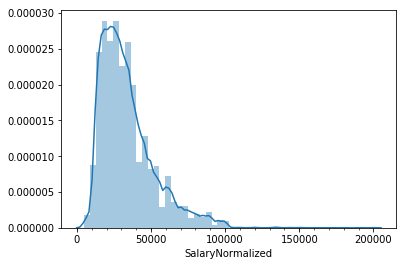

In [115]:
g = sns.distplot(df_enrich.SalaryNormalized.dropna())
g.axes.set_xticks(range(0, 200_000, 10_000), minor=True)
g

Cleaner is very sharp

In [116]:
def plot_role_salary(role, rug=True, **kwargs):
    return sns.distplot(df_enrich[df_enrich['role_1'] == role].SalaryNormalized.dropna(), rug=rug, **kwargs)

The salary for a cleaner is very sharp around 12,000.

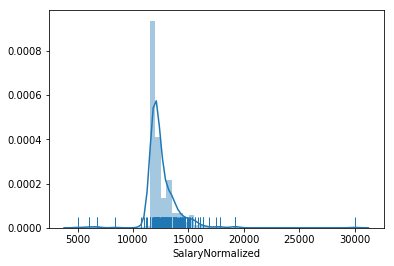

In [117]:
plot_role_salary('cleaner')

The very high salary example is misparsed

Misparse: (6.25 + 25) / 2 * 2000 = 31,250

Actual 6.25 * 2000 = 12,500

In [118]:
df_enrich[(df_enrich.role_1 == 'cleaner') & (df_enrich.SalaryNormalized > 25000)]

,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName,split,SalaryRaw,SalaryNormalized,uid,role_1,role_2,role_3,role_4,role_5
Id,,,,,,,,,,,,,,,,,,
69168168,Cleaner at Winsford Industrial Estate,We require an exceptional cleaner to service our client at a brand new ...,"Winsford, Cheshire Cheshire North West",Winsford,None,permanent,Quinplex,Customer Services Jobs,totaljobs.com,Train,6.25 per hour 25 hours per week,30000.0,69168168,cleaner,None,None,None,None


The lowest cleaner salaries are low because they are all part time

1. 6.19/hour = 12,380/year (Not 6,720)
2. 20 hours per week: 6,000/year = 12,000 FTE/year
3. 20 hours per week: 140/week ~ 7000/year ~ 14000 FTE/year
4. 6.25/hour = 12,500/year (not 6,009)
5. 15 hours per week: 4,349-5,662/year ~ 13,350 FTE/year
6. Hours per week censored

In [119]:
df_enrich[(df_enrich.role_1 == 'cleaner') & (df_enrich.SalaryNormalized < 10000)]

,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName,split,SalaryRaw,SalaryNormalized,uid,role_1,role_2,role_3,role_4,role_5
Id,,,,,,,,,,,,,,,,,,
67106622,Cleaner,Working on varied cleaning tasks in a friendly team. The OCS Group is o...,Barnsley,Barnsley,part_time,None,OCS Group Ltd,Maintenance Jobs,Jobcentre Plus,Train,60.00 - 220.00 per week 6.19 per hour,6720.0,67106622,cleaner,None,None,None,None
68237784,Cleaner,We currently require a Cleaner to work 20hrs per week including evening...,Towcester,Towcester,part_time,None,Serco Group Plc,Other/General Jobs,Jobcentre Plus,Train,"6,000.00 per year",6000.0,68237784,cleaner,None,None,None,None
69013620,Cleaner,Cleaner required for 20 hours per week 06001000 Monday to Friday. CRB c...,"Tewkesbury, Gloucestershire",Tewkesbury,None,permanent,Adecco,Other/General Jobs,cv-library.co.uk,Train,140/week,6720.0,69013620,cleaner,None,None,None,None
69553550,CLEANER,Previous cleaning experience essential and you must have good written a...,DUDLEY,Dudley,part_time,None,Boxer Facilities Management,Maintenance Jobs,Jobcentre Plus,Train,0.01 - 0.01 per hour 6.25 Per Hour,6009.0,69553550,cleaner,None,None,None,None
71439782,Cleaner,"Salary Grade A, Spinal Column Point **** **** to **** per annum 15 hour...",Greater Manchester,Manchester,part_time,permanent,GODLEY COMMUNITY PRIMARY SCHOOL,Teaching Jobs,jobs.guardian.co.uk,Train,"4,349 to 5,662 per annum",5005.0,71439782,cleaner,None,None,None,None
71873439,Cleaner,"Salary: **** Band 1, SCP **** Established Term Time Only Hours: ****hpw...",North Yorkshire,North Yorkshire,part_time,contract,BROMPTON HALL SPECIAL SCHOOL,Teaching Jobs,jobs.guardian.co.uk,Train,"8,404.39",8404.0,71873439,cleaner,None,None,None,None


## Business development manager

This is a broader role with a much broader salary, but a single peak near 30,000.

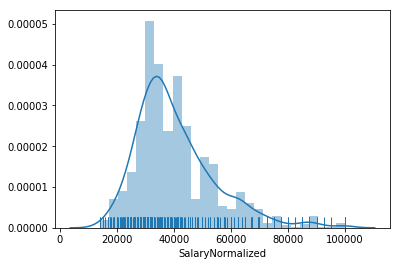

In [120]:
plot_role_salary('business development manager')

A Chef de Partie has a sharply defined salary

In [121]:
df_enrich[df_enrich.role_1 == 'chef de partie'].SalaryNormalized.median()

17500.0

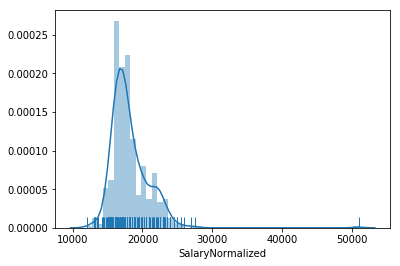

In [122]:
plot_role_salary('chef de partie')

The outlier is in Australia; it's a completely different currency!

In [123]:
df_enrich[(df_enrich.role_1 == 'chef de partie') & (df_enrich.SalaryNormalized > 30000)]

,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName,split,SalaryRaw,SalaryNormalized,uid,role_1,role_2,role_3,role_4,role_5
Id,,,,,,,,,,,,,,,,,,
68587078,Chef De Partie FIRST CLASS Lounge,The Company Trippas White Group is one of Australia's leading restauran...,Sydney,UK,None,permanent,Trippas White Group,Travel Jobs,tntjobs.co.uk,Train,$50000.00 to $52000.00,51000.0,68587078,chef de partie,None,None,None,None


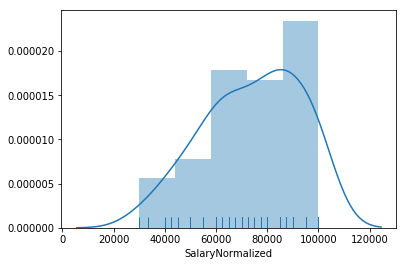

In [124]:
plot_role_salary('sales director')

1. to 60,000+ comm is not the same at 30,000!
2. Hospitality job
3. Hospitality job
4. Hospitality job

Seens to depend a lot in the type of job

In [125]:
df_enrich[(df_enrich.role_1 == 'sales director') & (df_enrich.split=='Train')].sort_values('SalaryNormalized').T

Id,71170921,69473472,61502668,70735592,69004177,71170916,71125844,68179764,72490557,69000431,71340288,72238168,71170915,69779034,69249868,68754125,69586549,68291689,69139445,68580366,68678450,68703311,70028500,70251153,71443853,71170924,66936316,68291643,71170920,68822606,68836340,68998691,69121998,72244671,69475911,69635427,72192982,66784835,69573989,68651251,70607615,72235363,67321662,69585343,71834436,69986730,70256656,71341567,68291472,69249658,71678385,72400203,69121955,71596704,71110083,72440056,60276305,71083034,70448128,68096243,67244445,64753304,71693141,72604010
Title,Sales Director Conferences /,Sales Director,Director of Sales,Director of Sales,Sales Director Commercial Solutions Sales,Sales Director Healthcare,Sales Director,Sales Director,Sales Director Midlands,Sales Director/Business Development Manager Mobile Apps,Sales Director/Business Development Manager – Mobile Apps,"Sales Director Erith, Kent",Sales Director International,Sales Director,Sales Director,Sales director,Sales Director,Sales Director,Business Development & Sales Director,Business Development & Sales Director,Sales Director USA,Sales Director,Sales Director,Sales Director Prestigious Scientific Recruitment Brand Manchester,Sales Director Bespoke Unitized Facades,Sales Director,Sales Director,Sales Director SaD/****/****,Sales Director Digital,Sales Director Electrical/cables Rail,Sales Director Electrical/cables Rail,Sales Director,Sales Director,Sales Director,Sales Director EMEA VOD/Mobile,Sales Director – Communications & Managed Services – UK Wide – ESP ****,Sales Director SD/A/****/****,Sales Director,Sales Director SalD/****/****,Sales Director / Managing Director Designate,Sales Director,Sales Director / Managing Director Designate,Sales Director Agency and Brand,"Sales Director Japan, 89M bonus Japanese Yen",Sales Director,Director of Sales (iGaming),Sales Director,Sales Director,Sales Director SD/****/****,Sales Director,Sales Director SD/****/****,Sales Director in Media with French,Sales Director UK SDUK/****/****,Sales Director / Managing Director Designate,Sales Director SD/****/****,Sales Director Healthcare,"Sales Director,Technical Recruitment–North England",Sales Director,Sales Director SD/****/****,Sales Director,Sales Director Jewellery,Sales Director Commercial Vehicle Solutions,Sales Director Jewellery,Sales Director
FullDescription,"Sales Director Conferences / to **** comm Our client, a leading confe...","Holiday Inn hotels look for people who are genuine, friendly, thoughtfu...",Our client is seeking a Director of Sales to join their successful team...,"Director of Sales, DOS, Director of Sales Ahead of exciting plans our c...",Sales Director Commercial Solutions Sales Peterborough (East Midlands) ...,"Sales Director Healthcare **** **** (OTE ****K) benefits Our client,...",Sales Director Home Based or South West **** **** negotiable plus pack...,"Self motivated, experienced sales Director to manage a sales team in th...",Job Title: Sales Director Location: Midlands Package: &pound**** &poun...,Sales Director/Business Development Manager Mobile Applications Ref: *...,Sales Director/Business Development Manager Mobile Applications Ref: *...,"Sales Director Erith, Kent Do you have sales director experience with ...","Sales Director International **** Comm Our client, a global digital A...",Amberley is a leading book publisher in the local and specialist histor...,Job Title Sales Director Location Scunthorpe Sector Manufacturing Pa...,Job Title: Sales Director Company: Shoreditch Energy Salary: Basic ****...,Our client is a successful and progressive print company who have made ...,My client is a specialist manufacturer of water treatment equipment for...,A leading investment manager who offer a range of tax efficient investm...,The Role: Work in partnership with IFA networks and individuals to ens...,"Duties include: Sales Strategy, Sales Management, budgeting forecasting...",Sales Director Solutions selling Customer Expe

## Analysing groups of roles

In [126]:
def plot_role_salary_dists(role, min_freq=100):
    _roles = flat_roles[flat_roles.index.str.contains(role) & (flat_roles.role > min_freq)]
    order = df_enrich[df_enrich.role_1.isin(_roles.index)].groupby('role_1')['SalaryNormalized'].median().sort_values(ascending=False).index
    g = sns.violinplot(y='role_1', x='SalaryNormalized', bw='scott', hue='hue',
                       data=df_enrich[df_enrich.role_1.isin(_roles.index)].assign(hue=1), orient='h',
                       width=0.8, order=order, scale='width')

    g.legend('')
    g.set(xlabel='Annual Salary', ylabel='Role')
    return g

We can see that as Head Chef is the most senior role.

Sous chef (second in command) is behind, but hard to distinuish from pastry chef and junior sous chef.

Chef de partie (line manager) is a less senior, and just above a Demi Chef de Partie.

A Commis Chef is the lowest level, and in fact is paid similarly to a cook.

Chef is a broad term, but rarely used for specialist roles (sous or pastry).

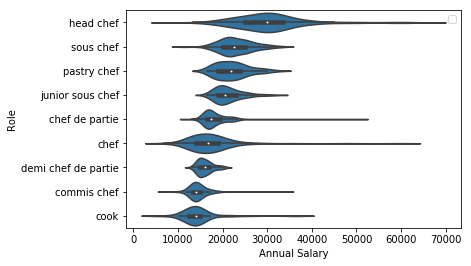

In [127]:
plot_role_salary_dists('chef|cook')

The Human Resources chain of command (in this dataset):

Assistant ~ Administrator < Officer ~ Advisor < Manager ~ Partner

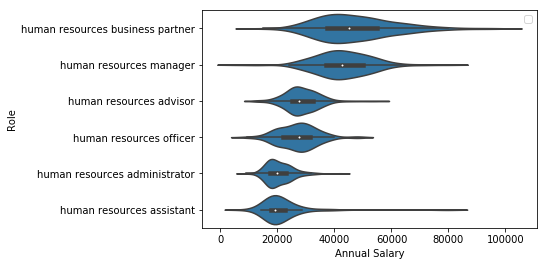

In [139]:
plot_role_salary_dists('human resources')

Developers are hard to distinguish from salary alone, though web developers tend to be more poorly paid than systems and app developers.

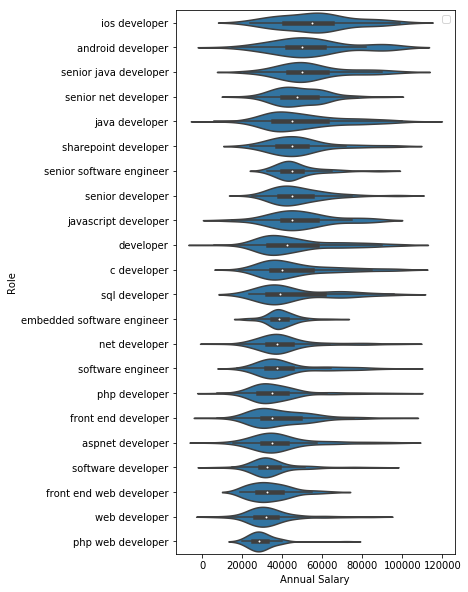

In [140]:
plt.figure(figsize=(5,10))
plot_role_salary_dists('developer|software engineer')

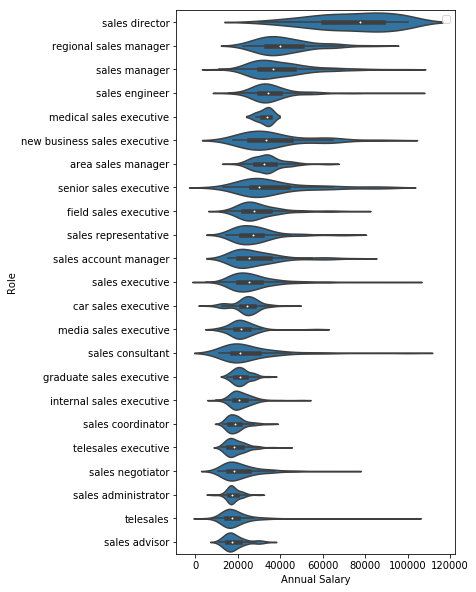

In [130]:
plt.figure(figsize=(5,10))
plot_role_salary_dists('sales')

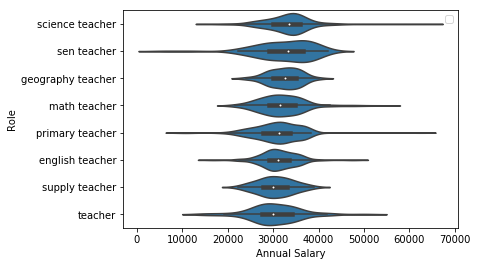

In [131]:
plot_role_salary_dists('teacher')

Recruitment is a pretty straightline path

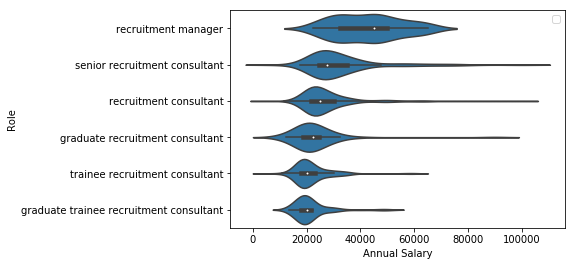

In [132]:
plot_role_salary_dists('recruit')

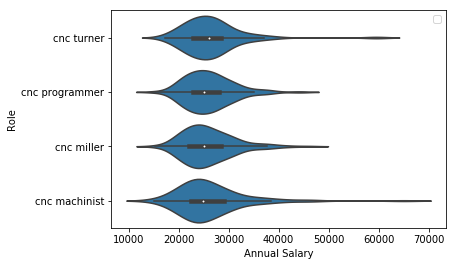

In [141]:
plot_role_salary_dists('cnc')